<div style="
    background: linear-gradient(135deg, #4A90E2, #007AFF);
    padding: 20px;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.2);
    margin-bottom: 20px;
">
  <h1 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;">
    PROJET HUMAN FOR YOU
  </h1>
  <h3 style="color:#EAF2FB; text-align:center; margin-top:10px; font-weight:normal;">
    Prédiction de l'Attrition des Employés
  </h3>
</div>

<div style="
    border-left: 6px solid #4A90E2;
    padding: 18px 22px;
    border-radius: 8px;
    font-size: 16px;
    line-height: 1.6;
    text-align: justify;
    box-shadow: 0 2px 5px rgba(0,0,0,0.05);
">
  <p>
    Ce notebook présente l'intégralité du pipeline de <strong>Machine Learning</strong> pour prédire quels employés sont susceptibles de quitter l'entreprise.
  </p>
  
  <p><strong>Objectifs et déroulement du projet :</strong></p>
  
  <ol style="padding-left:25px;">
    <li style="margin-bottom:8px;">Charger les données nettoyées et normalisées.</li>
    <li style="margin-bottom:8px;">Analyser les facteurs d'influence (identifier les causes de départ et de rétention).</li>
    <li style="margin-bottom:8px;">Entraîner 9 modèles différents (incluant XGBoost et Réseaux de Neurones).</li>
    <li style="margin-bottom:8px;">Comparer les performances des modèles (métriques : Recall, F1-Score).</li>
    <li style="margin-bottom:8px;">Visualiser les erreurs (matrices de confusion) et l'importance des variables.</li>
  </ol>
</div>

<div style="background-color:#4A90E2; padding:12px; border-radius:10px; margin-bottom:15px; margin-top:20px;">
  <h2 style="color:white; text-align:center; margin:0;">1. Initialisation de l'environnement</h2>
</div>

<div style="
    border-left:6px solid #4A90E2; 
    padding:15px; 
    border-radius:8px;
    box-shadow:0px 2px 5px rgba(0,0,0,0.05);
">
  <p style="margin-bottom:10px; font-size:16px;">
    Cette première étape permet d'importer l'ensemble des bibliothèques Python nécessaires au bon fonctionnement du projet :
  </p>
  <ul style="padding-left:20px; line-height:1.6;">
     <li style="margin-bottom:5px;"><strong>Pandas & Numpy :</strong> Pour la manipulation des tableaux de données et le calcul matriciel.</li>
     <li style="margin-bottom:5px;"><strong>Seaborn & Matplotlib :</strong> Pour la visualisation graphique et l'analyse exploratoire.</li>
     <li style="margin-bottom:5px;"><strong>Scikit-Learn & XGBoost :</strong> Pour la construction des modèles d'IA et l'évaluation des performances.</li>
  </ul>
</div>

In [13]:
import pandas as pd #Lire les fichiers CSV
import matplotlib.pyplot as plt
import seaborn as sns #Visualisation des donnees
import time
import numpy as np
# Imports des differentes IA pour le Machine Learning
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, confusion_matrix, roc_curve
# Configuration de seaborn pour des graphiques plus jolis
sns.set_theme(style="whitegrid")

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 1. Chargement et Analyse Exploratoire </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> Nous commençons par charger le fichier CSV et analyser les corrélations pour comprendre les facteurs positifs (départ) et négatifs (rétention). </p>

<p><strong>🔎 Fonctionnement du script :</strong></p>

<ul style="padding-left:25px;"> <li style="margin-bottom:8px;"> <strong>Importation sécurisée :</strong> La fonction <code>charger_donnees</code> récupère le dataset et vérifie son intégrité (dimensions) tout en gérant les erreurs de fichier introuvable. </li> <li style="margin-bottom:8px;"> <strong>Analyse statistique :</strong> Le code calcule les corrélations pour isoler les variables qui impactent le plus la cible <em>Attrition</em>. </li> <li style="margin-bottom:8px;"> <strong>Visualisation sémantique :</strong> La fonction <code>analyser_facteurs_influents</code> traduit les chiffres en un graphique décisionnel clair :


🔴 <strong>Rouge</strong> : Ce qui pousse au départ (Corrélation positive).


🟢 <strong>Vert</strong> : Ce qui retient les employés (Corrélation négative). </li> </ul> </div>

In [ ]:
def charger_donnees(chemin):
    """Charge le fichier csv et affiche le nombre de lignes et de colonnes."""
    print(f" Chargement du fichier : {chemin}...")
    try:
        df = pd.read_csv(chemin)
        print(f" Données chargées : {df.shape[0]} lignes, {df.shape[1]} colonnes.")
        return df
    except FileNotFoundError:
        print(f" Erreur : Le fichier '{chemin}' est introuvable.")
        return None
def analyser_facteurs_influents(df):
    """
    1. Affiche l'influence (Barres).
    2. Affiche la matrice de corrélation complète découpée en bandes verticales (cote à cote).
    """
    print("\n🔍 Analyse des facteurs clés et corrélations...")
    
    # Préparation des données
    df_calc = df.copy()
    if df_calc['Attrition'].dtype == 'object':
        try:
            df_calc['Attrition'] = df_calc['Attrition'].map({'Yes': 1, 'No': 0})
        except: pass

    # --- 1. LE CLASSEMENT (Barplot) ---
    corr_all = df_calc.corr(numeric_only=True)['Attrition'].sort_values(ascending=False)
    corr_all = corr_all.drop('Attrition', errors='ignore')
    top_corr = pd.concat([corr_all.head(10), corr_all.tail(10)])
    
    plt.figure(figsize=(12, 6))
    colors = ['#e74c3c' if x > 0 else '#2ecc71' for x in top_corr.values]
    sns.barplot(x=top_corr.values, y=top_corr.index, hue=top_corr.index, palette=colors, legend=False)
    plt.title("Facteurs déterminants : Rouge = Risque de Départ | Vert = Rétention")
    plt.axvline(x=0, color='black', linestyle='--')
    plt.show()

    # --- 2. LES HEATMAPS COTE A COTE (Découpage) ---
    print("   Génération des Heatmaps en bandes verticales...")
    
    # Calcul de la matrice complète
    corr_matrix = df_calc.corr(numeric_only=True)
    cols = corr_matrix.columns
    n_vars = len(cols)
    
    # Paramètres de découpage (5 colonnes par graphique)
    chunk_size = 5
    num_chunks = (n_vars + chunk_size - 1) // chunk_size # Calcul du nombre de graphiques nécessaires
    
    # Création de la figure globale
    # Largeur dynamique : on compte de la place pour chaque bande + les labels à gauche
    # Hauteur dynamique : dépend du nombre de variables total (lignes)
    fig, axes = plt.subplots(nrows=1, ncols=num_chunks, 
                             figsize=(num_chunks * 3 + 2, n_vars * 0.4), 
                             sharey=True) # sharey=True permet de n'avoir les noms des variables qu'une seule fois à gauche
    
    # Si une seule bande est nécessaire, axes n'est pas une liste, on corrige pour éviter les bugs
    if num_chunks == 1: axes = [axes]
    
    for i in range(num_chunks):
        # Sélection des colonnes pour cette bande (ex: colonnes 0 à 5, puis 5 à 10...)
        start = i * chunk_size
        end = min((i + 1) * chunk_size, n_vars)
        chunk_cols = cols[start:end]
        
        # On prend TOUTES les lignes, mais seulement les colonnes du groupe
        sub_matrix = corr_matrix.loc[:, chunk_cols]
        
        # Affichage sur le sous-graphique correspondant (axes[i])
        ax = axes[i]
        is_last = (i == num_chunks - 1) # Pour savoir si on met la barre de couleur à la fin
        
        sns.heatmap(sub_matrix, 
                    ax=ax,
                    annot=True, 
                    fmt=".1f", 
                    cmap='coolwarm', 
                    center=0, vmin=-1, vmax=1,
                    cbar=is_last, # Barre de couleur uniquement sur le dernier graphique pour gagner de la place
                    cbar_kws={"shrink": 0.5} if is_last else None,
                    linewidths=0.5,
                    annot_kws={"size": 8}) # Taille de police ajustée
        
        # Titre et nettoyage des axes
        ax.set_title(f"Variables {start+1}-{end}")
        ax.tick_params(axis='x', rotation=45)
        ax.set_xlabel("")
        ax.set_ylabel("")
        
    plt.suptitle("Matrice de Corrélation Complète (Vue Panoramique)", y=1.01, fontsize=16)
    plt.tight_layout()
    plt.show()

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 2. Préparation des Données (Data Splitting) </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> Pour évaluer correctement nos modèles, nous ne pouvons pas les tester sur les données qu'ils ont déjà vues. Nous séparons donc la cible (<code>Attrition</code>) des caractéristiques (<code>X</code>) et découpons le jeu de données en deux parties distinctes : </p>

<ul style="padding-left:25px;"> <li style="margin-bottom:8px;"> <strong>🏋️ Train set (70%)</strong> : Utilisé pour l'entraînement des modèles (l'apprentissage). </li> <li style="margin-bottom:8px;"> <strong>📝 Test set (30%)</strong> : Gardé secret jusqu'à la fin pour évaluer la performance réelle (la validation). </li> </ul>

<p><strong>Focus Technique :</strong></p>

<ul style="padding-left:25px;"> <li style="margin-bottom:8px;"> <strong>Stratification (<code>stratify=y</code>) :</strong> C'est l'élément clé ici. Comme les départs sont rares (environ 15%), une découpe aléatoire pourrait créer un jeu de test sans aucun départ. La stratification force la répartition des classes à être identique dans le <em>Train</em> et le <em>Test</em>. </li> <li style="margin-bottom:8px;"> <strong>Reproductibilité :</strong> Le paramètre <code>random_state=42</code> fige le hasard pour obtenir toujours le même découpage à chaque exécution. </li> </ul> </div>

In [15]:
def preparation_donnees(df):
    """Prépare les données pour l'IA (Split 70/30)."""
    print(" Préparation des données (Train/Test Split)...")
    
    y = df['Attrition']
    X = df.drop('Attrition', axis=1) # on retire la colonne cible 
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    ) # Sépare les données en deux jeux : entraînement et test
    
    print(f"   Train set : {X_train.shape[0]} employés") # Nombre d'employés dans le train
    print(f"   Test set  : {X_test.shape[0]} employés")
    return X_train, X_test, y_train, y_test, X.columns

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 3. Entraînement et Comparaison des Modèles </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> Dans cette phase critique, nous lançons une compétition entre <strong>9 algorithmes différents</strong>. L'objectif est de dépasser la performance d'une simple déduction humaine en testant des approches variées, allant des statistiques classiques (Régression Logistique) aux méthodes avancées (Boosting, Réseaux de Neurones). </p>

<p><strong> Stratégie d'évaluation :</strong></p>

<ul style="padding-left:25px;"> <li style="margin-bottom:8px;"> <strong>Pourquoi pas juste l'Accuracy ?</strong> Dans notre cas, 85% des employés restent. Un modèle qui prédit "Tout le monde reste" aurait 85% de réussite, mais serait <em>inutile</em>. </li> <li style="margin-bottom:8px;"> <strong>🎯 Le Recall (Rappel) :</strong> C'est notre priorité n°1. Il mesure notre capacité à <strong>ne pas rater un départ</strong>. Un Recall de 0.60 signifie qu'on détecte 60% des démissionnaires réels. </li> <li style="margin-bottom:8px;"> <strong>⚖️ Le F1-Score :</strong> C'est la moyenne harmonique entre la Précision et le Recall. Il nous assure que le modèle est équilibré et ne se contente pas de prédire "Départ" au hasard pour augmenter son score. </li> </ul> </div>

<div style="
    background: linear-gradient(135deg, #4A90E2, #007AFF);
    padding: 20px;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.2);
    margin-bottom: 20px;
">
  <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;">
    3.1 Modèle de Régression Logistique
  </h2>
</div>

<div style="
    border-left: 6px solid #4A90E2;
    padding: 18px 22px;
    border-radius: 8px;
    font-size: 16px;
    line-height: 1.6;
    text-align: justify;
    box-shadow: 0 2px 5px rgba(0,0,0,0.05);
">
  <p>
    La <strong>Régression Logistique</strong> est souvent utilisée comme "Baseline" (modèle de référence) en classification. Contrairement à une régression linéaire qui prédit une valeur continue, elle est conçue pour prédire une probabilité d'appartenance à une classe (ici : Départ ou Reste).
  </p>
  
  <p><strong>📊 Le concept mathématique :</strong></p>
  
  <p>
    Pour transformer le résultat en une probabilité comprise entre 0 et 1, l'algorithme utilise une fonction d'activation appelée <strong>Sigmoïde</strong>. C'est elle qui permet de décider : si la probabilité > 50%, on prédit "Départ" (1), sinon "Reste" (0).
  </p>
</div>

## La Formule de la Sigmoïde $$P (y=1 | x) = \frac {1}{1+e^{-(w \cdot x + b)}}$$

- **$w$ (Poids) :** L'importance de chaque variable (ex: le salaire a-t-il un gros poids ?).
- **$x$ (Variable) :** Les données de l'employé.
- **$b$ (Biais) :** L'ordonnée à l'origine (le point de départ).

<div style="
    border-left: 6px solid #4A90E2;
    padding: 0px 22px 18px 22px;
    border-radius: 0 0 8px 8px;
    font-size: 16px;
    line-height: 1.6;
    box-shadow: 0 2px 5px rgba(0,0,0,0.05);
">
  <p style="font-size: 0.9em; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;">
    <em>Sources & Références : 
      <a href="https://www.ibm.com/fr-fr/think/topics/logistic-regression" target="_blank">IBM Watson</a> | 
      <a href="https://numiqo.fr/tutorial/logistic-regression" target="_blank" style="color:#4A90E2;">Numiqo</a>
    </em>
  </p>
</div>

<div style="
    background: linear-gradient(135deg, #4A90E2, #007AFF);
    padding: 20px;
    border-radius: 12px;
    box-shadow: 0 4px 12px rgba(0,0,0,0.2);
    margin-bottom: 20px;
">
  <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;">
    3.2 Modèle de Perceptron
  </h2>
</div>

<div style="
    border-left: 6px solid #4A90E2;
    padding: 18px 22px;
    border-radius: 8px 8px 0 0;
    font-size: 16px;
    line-height: 1.6;
    text-align: justify;
    box-shadow: 0 2px 5px rgba(0,0,0,0.05);
">
  <p>
    Le <strong>Perceptron</strong> est l'unité fondamentale du Deep Learning. Inspiré de la biologie, il imite le fonctionnement d'un neurone unique. C'est un classifieur linéaire qui apprend à séparer les données en ajustant ses poids via la <em>Perceptron Learning Rule</em>.
  </p>
  
  <p><strong>⚡ Mécanisme "Tout ou Rien" :</strong></p>
  
  <p>
    Le neurone reçoit des signaux (les données employés), les pondère (importance du signal), et fait la somme. Si cette somme dépasse un certain seuil d'activation, le neurone "s'allume" (prédit un Départ), sinon il reste inactif (Reste).
  </p>
</div>

## La Fonction d'Activation (Heaviside)

## $$f(x) = \begin{cases}1 \quad \text{si } \mathbf{w}\cdot\mathbf{x} + b > 0 \\0 \quad \text{sinon}\end{cases}$$


- **$\mathbf{w}$ (Poids Synaptiques) :** Coefficient d'importance appris par le modèle pour chaque critère.
- **$\mathbf{x}$ (Input) :** Les caractéristiques de l'employé.
- **$b$ (Biais) :** Le seuil de déclenchement du neurone.

<div style="
    border-left: 6px solid #4A90E2;
    padding: 0px 22px 18px 22px;
    border-radius: 0 0 8px 8px;
    font-size: 16px;
    line-height: 1.6;
    box-shadow: 0 2px 5px rgba(0,0,0,0.05);
">
  <p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;">
    <em>Sources & Références : 
      <a href="https://datascientest.com/perceptron" target="_blank" style="color:#4A90E2;">DataScientest</a> | 
      <a href="https://pageperso.lis-lab.fr/~alexis.nasr/Ens/MASCO_AA/perceptron.pdf" target="_blank" style="color:#4A90E2;">Université d'Aix-Marseille (PDF)</a>
    </em>
  </p>
</div>

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 3.3 Modèle SVM </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> SVM (Support Vector Machine) trace une ligne, mais il cherche à la placer le plus loin possible des exemples de chaque camp. Il crée une "zone de sécurité" (marge) maximale pour ne pas se tromper sur les cas ambigus. </p>

<p> Il utilise les valeurs les plus proches de l'hyperplan comme <strong>vecteurs de support</strong>. </p>

<div style="text-align: center; margin: 20px 0;"> <img src="picture/SVM.webp" alt="Diagramme SVM montrant deux classes de points en 2D" style="max-width: 100%; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);"> </div>

<p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;"> <em>Source : <a href="https://towardsdatascience.com/support-vector-machine-with-scikit-learn-a-friendly-introduction-a2969f2ff00d/" target="_blank" style="color:#4A90E2;">Towards Data Science</a></em> </p> </div>

<div style="background: linear-gradient(135deg, #4A90E2, #007AFF);padding: 20px;border-radius: 12px;box-shadow: 0 4px 12px rgba(0,0,0,0.2);margin-bottom: 20px;"><h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;">3.4 Modèle KNN</h2></div><div style="border-left: 6px solid #4A90E2;padding: 18px 22px;border-radius: 8px;font-size: 16px;line-height: 1.6;text-align: justify;box-shadow: 0 2px 5px rgba(0,0,0,0.05);"><p>Le KNN (K-Nearest Neighbors) n'utilise pas de règle globale. Dès qu'une nouvelle valeur est entrée, il regarde les K voisins autour de celle-ci <strong>et</strong> détermine ainsi à quelle classe la valeur appartient.</p><div style="text-align: center; margin: 20px 0;"><img src="picture/KNN.png" alt="Schéma explicatif du KNN" style="max-width: 100%; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);"></div><p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;"><em>Sources : <a href="https://www.ibm.com/fr-fr/think/topics/knn#:~:text=IBM%20Research-,Qu%27est-ce%20que%20l%27algorithme%20KNN%20%3F,d%27un%20point%20de%20données" target="_blank" style="color:#4A90E2;">IBM</a> | <a href="https://datascientest.com/knn" target="_blank" style="color:#4A90E2;">DataScientest</a></em></p></div>

<div style="background: linear-gradient(135deg, #4A90E2, #007AFF);padding: 20px;border-radius: 12px;box-shadow: 0 4px 12px rgba(0,0,0,0.2);margin-bottom: 20px;"><h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;">3.5 Modèle Naive Bayes</h2></div><div style="border-left: 6px solid #4A90E2;padding: 18px 22px;border-radius: 8px;font-size: 16px;line-height: 1.6;text-align: justify;box-shadow: 0 2px 5px rgba(0,0,0,0.05);"><p>Le modèle Naive Bayes regarde les statistiques passées. Si on prend un exemple avec des fruits, on a alors : "Dans le passé, 90% des fruits ronds et rouges étaient des pommes".</p><p>Il calcule la probabilité pour le nouveau fruit et choisit la classe la plus probable, en supposant <strong>naïvement</strong> que la couleur et la forme n'ont aucun lien entre eux (indépendance des variables).</p><div style="padding: 15px;border-radius: 8px;border: 1px solid #e0e0e0;text-align: center;margin: 20px 0;"><strong>Formule de Bayes & Application :</strong>$$P(y | x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i | y)}{P(x_1, \dots, x_n)}$$<em>soit le principe de base :</em>$$P(A|B)= \frac{P(B|A) \cdot P(A)}{P(B)}$$</div><div style="text-align: center; margin: 20px 0;"><img src="picture/NAIVEBAYES.webp" alt="Illustration Naive Bayes" style="max-width: 100%; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);"></div><p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;"><em>Sources : <a href="https://www.datacamp.com/fr/tutorial/naive-bayes-scikit-learn" target="_blank" style="color:#4A90E2;">DataCamp</a> | <a href="https://mrmint.fr/naive-bayes-classifier" target="_blank" style="color:#4A90E2;">MrMint</a></em></p></div>

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 3.6 Modèle DecisionTree </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> Le <strong>Decision Tree</strong> (Arbre de Décision) divise les données étape par étape jusqu'à arriver à une conclusion. </p> <p> Il fonctionne comme un grand organigramme : à chaque nœud, il pose une question sur une variable (ex: "Heures sup > 10h ?") pour séparer les employés en groupes de plus en plus homogènes. </p>

<div style="text-align: center; margin: 20px 0;"> <img src="picture/DESICIONTREE.png" alt="Schéma Decision Tree" style="max-width: 100%; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);"> </div>

<p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;"> <em>Source : <a href="https://scikit-learn.org/stable/modules/tree.html" target="_blank" style="color:#4A90E2;">Scikit-learn Documentation</a></em> </p> </div>

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 3.7 Modèle RandomForest </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> Il crée des centaines d'arbres de décision différents (en leur donnant des données légèrement variées). À la fin, tous les arbres "votent". </p>

<p><strong>🌲 Le mécanisme de vote :</strong></p> <p> La nouvelle valeur passe par un arbre et arrive à une conclusion. Le même fonctionnement s'applique pour l'arbre suivant, et ainsi de suite. </p> <p> À la fin, on regarde quelle conclusion apparaît le plus de fois : la valeur sera alors classée selon la <strong>majorité</strong>. </p>

<div style="text-align: center; margin: 20px 0;"> <img src="picture/RANDOMFOREST.jpg" alt="Schéma Random Forest" style="max-width: 100%; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);"> </div>

<p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;"> <em>Source : <a href="https://www.devoteam.com/fr/expert-view/algorithme-n2-comprendre-comment-fonctionne-un-random-forest-en-5-min/#:~:text=Le%20random%20forest%20est%20un,il%20produit%20des%20résultats%20généralisables" target="_blank" style="color:#4A90E2;">Devoteam</a></em> </p> </div>

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 3.8 Modèle XGBoost </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> <strong>XGBoost</strong> (Extreme Gradient Boosting) construit des arbres les uns après les autres. </p>

<p><strong>🚀 Le principe de correction :</strong></p> <p> Chaque nouvel arbre se concentre spécifiquement sur les <strong>erreurs commises par les précédents</strong> pour les corriger. C'est une amélioration itérative. </p> <p> C'est actuellement considéré comme le modèle le plus performant pour les données tabulaires structurées (tableaux Excel). </p>

<div style="text-align: center; margin: 20px 0;"> <img src="picture/XGBOOST.png" alt="Schéma XGBoost" style="max-width: 100%; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);"> </div>

<p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;"> <em>Source : <a href="https://pro.arcgis.com/fr/pro-app/3.4/tool-reference/geoai/how-xgboost-works.htm#:~:text=XGBoost%20signifie%20extreme%20gradient%20boosting,à%20diverses%20méthodes%20d%27optimisation" target="_blank" style="color:#4A90E2;">ArcGIS Pro - Documentation</a></em> </p> </div>

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 3.9 Modèle Réseau de Neurones </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> Ce modèle connecte des "neurones" artificiels en plusieurs <strong>couches successives</strong>. </p>

<p><strong>🧠 L'apprentissage hiérarchique :</strong></p> <p> Le réseau fonctionne par étapes de plus en plus abstraites :


• La <strong>première couche</strong> détecte des formes simples (ex: des bords).


• La <strong>suivante</strong> assemble ces formes (ex: un rond).


• La <strong>dernière</strong> analyse le tout et prend la décision finale. </p>

<p> C'est une <strong>"boîte noire"</strong> très puissante, capable de gérer des données complexes et non-linéaires là où les autres modèles peinent. </p>

<div style="text-align: center; margin: 20px 0;"> <img src="picture/RESEAUNEURONES.png" alt="Schéma Réseau de Neurones" style="max-width: 100%; border-radius: 8px; box-shadow: 0 2px 8px rgba(0,0,0,0.1);"> </div>

<p style="font-size: 0.9em; color: #666; border-top: 1px solid #ddd; padding-top: 10px; margin-top: 15px;"> <em>Source : <a href="https://www.ibm.com/fr-fr/topics/neural-networks" target="_blank" style="color:#4A90E2;">IBM - Neural Networks</a></em> </p> </div>

In [16]:
def entrainer_modeles(X_train, X_test, y_train, y_test):
    """Entraîne une liste de modèles et compare les résultats."""

    # Definition des modèles à tester
    models = {
        "LogisticRegression": LogisticRegression(max_iter=1000, random_state=42),
        "Perceptron": Perceptron(random_state=42),
        "SVM": SVC(probability=True, random_state=42),
        "KNN": KNeighborsClassifier(),
        "NaiveBayes": GaussianNB(),
        "DecisionTree": DecisionTreeClassifier(random_state=42),
        "RandomForest": RandomForestClassifier(n_estimators=100, random_state=42),
        "XGBoost": XGBClassifier(eval_metric='logloss', random_state=42),
        "ReseauNeuronal": MLPClassifier(max_iter=1000, random_state=42)
    }
    
    results = []
    trained_models = {}

    print("\n Début de l'entraînement des modèles...")
    print("-" * 60)

    for name, model in models.items():
        start_time = time.time()
        model.fit(X_train, y_train) # On entraine les modèles
        y_pred = model.predict(X_test) # Prédictions sur le jeu de test

        # On teste 5 fois le modèle sur des bouts différents de X_train
        scores = cross_val_score(model, X_train, y_train, cv=5, scoring='recall')
        cv_mean = scores.mean()  # Moyenne des 5 scores
        cv_std = scores.std()    # Écart-type (stabilité)
        duration = time.time() - start_time
        
        try:
            y_proba = model.predict_proba(X_test)[:, 1] # Probabilité que l'employé parte
            auc = roc_auc_score(y_test, y_proba) # On évalue la qualité globale du modèle
        except:
            auc = 0
       # Stockage des métriques du modèle
        results.append({
            'Modèle': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred),
            'Recall': recall_score(y_test, y_pred),
            'CV Recall Moyen': cv_mean,
            'CV Ecart-Type': cv_std,   
            'F1-Score': f1_score(y_test, y_pred),
            'AUC': auc,
            'Temps (s)': duration
        })
        # Sauvegarde du modèle entraîné
        trained_models[name] = model
        print(f"   🔹 {name:<20} | Recall Test: {recall_score(y_test, y_pred):.3f} | CV Recall Moy: {cv_mean:.3f}")
    # Retourne le DataFrame récapitulatif et les modèles entraînés
    return pd.DataFrame(results), trained_models

<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 4. Visualisation des Résultats </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> Une fois les modèles entraînés, nous devons "ouvrir le capot" pour comprendre leurs décisions et vérifier leur fiabilité réelle via deux outils principaux : </p>

<ul style="padding-left:25px;"> <li style="margin-bottom:15px;"> <strong>📉 Matrices de Confusion :</strong>


C'est la "table de vérité" du modèle. Elle nous permet de voir précisément :


• Combien de départs ont été <strong>correctement anticipés</strong> (Vrais Positifs).


• Combien de départs ont été <strong>manqués</strong> (Faux Négatifs - le pire scénario pour les RH). </li> <li style="margin-bottom:8px;"> <strong>📊 Importance des Variables :</strong>


Pour comprendre quelles caractéristiques pèsent le plus dans la décision du meilleur modèle (généralement XGBoost ou Random Forest).


<em>Exemple : Est-ce le salaire, la distance domicile-travail ou les heures supplémentaires qui provoquent le plus de départs ?</em> </li> </ul> </div>

In [17]:
def afficher_matrice_confusion(y_test, trained_models, X_test):
    """Affiche les matrices de confusion."""
    print("\n Génération des matrices de confusion...")
    plt.figure(figsize=(15, 12))
    
    for i, (name, model) in enumerate(trained_models.items()):
        y_pred = model.predict(X_test)  # Prédiction des labels sur le jeu de test
        cm = confusion_matrix(y_test, y_pred) # Calcul de la matrice de confusion
        
        plt.subplot(3, 3, i+1)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False) # Affichage de la matrice de confusion avec Seaborn
        plt.title(name)
        plt.ylabel('Réel')
        plt.xlabel('Prédit')
    
    plt.tight_layout() # Ajuste l'espacement pour éviter les chevauchements
    plt.show()

def afficher_importance_variables(trained_models, feature_names):
    """Affiche l'importance des variables pour le meilleur modèle 'Arbre' disponible."""
    model_choisi = None
    nom_modele = ""

    # Choix du modèle arbre pour récupérer l'importance des features
    if "XGBoost" in trained_models: # Priorité à XGBoost
        model_choisi = trained_models["XGBoost"]
        nom_modele = "XGBoost"
    elif "RandomForest" in trained_models: # Sinon Random Forest
        model_choisi = trained_models["RandomForest"]
        nom_modele = "Random Forest"
    
    if model_choisi:
        print(f"\n Analyse des causes réelles du départ (Basé sur : {nom_modele})...")
        importances = model_choisi.feature_importances_
        feature_imp_df = pd.DataFrame({
            'Variable': feature_names,
            'Importance': importances
        }).sort_values(by='Importance', ascending=False).head(15) # Top 15 des variables les plus importantes
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Variable', hue='Variable', data=feature_imp_df, palette='magma', legend=False)
        plt.title(f"TOP 15 des variables les plus importantes ({nom_modele})")
        plt.show()
    else:
        print("Aucun modèle compatible pour l'analyse d'importance.")


def comparer_roc_auc_visuel(models, X_test, y_test):
    """
    Trace les courbes ROC de tous les modèles sur un seul graphique.
    Renvoie le nom du meilleur modèle (AUC le plus élevé).
    """
    print("\n📊 Génération de la comparaison ROC/AUC...")
    plt.figure(figsize=(12, 8))
    
    best_auc = 0
    best_model_name = ""
    
    # On parcourt chaque modèle entraîné
    for name, model in models.items():
        y_proba = None
        
        try:
            # Récupération des probabilités (nécessaire pour la courbe ROC)
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test)[:, 1]
            elif hasattr(model, "decision_function"): # Cas du SVM ou Perceptron parfois
                y_proba = model.decision_function(X_test)
            
            if y_proba is not None:
                # Calcul des coordonnées de la courbe
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                auc_score = roc_auc_score(y_test, y_proba)
                
                # Mise à jour du champion
                if auc_score > best_auc:
                    best_auc = auc_score
                    best_model_name = name
                
                # Ajout de la courbe
                plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {auc_score:.3f})")
        except Exception as e:
            print(f"Skipping ROC for {name}: {e}")

    # Esthétique du graphique
    plt.plot([0, 1], [0, 1], 'k--', linestyle='--', color='grey', label="Hasard (AUC = 0.5)")
    plt.xlabel("Taux de Faux Positifs (Erreurs d'alerte)")
    plt.ylabel("Taux de Vrais Positifs (Détections correctes)")
    plt.title("Comparaison : Quel modèle sépare le mieux les départs ?")
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.show()
    
    print(f"🏆 Le modèle champion est : {best_model_name} avec un AUC de {best_auc:.3f}")
    return best_model_name


<div style=" background: linear-gradient(135deg, #4A90E2, #007AFF); padding: 20px; border-radius: 12px; box-shadow: 0 4px 12px rgba(0,0,0,0.2); margin-bottom: 20px; "> <h2 style="color:white; text-align:center; font-family:Arial, sans-serif; margin:0;"> 5. Exécution Principale </h2> </div>

<div style="border-left: 6px solid #4A90E2; padding: 18px 22px; border-radius: 8px; font-size: 16px; line-height: 1.6; text-align: justify; box-shadow: 0 2px 5px rgba(0,0,0,0.05); "> <p> <strong> Lançons le pipeline complet !</strong> </p>

<p> Cette section finale agit comme un chef d'orchestre. Elle appelle séquentiellement toutes les fonctions définies plus haut pour réaliser le processus de bout en bout : </p>

<ol style="padding-left:25px;"> <li style="margin-bottom:8px;"><strong>Chargement</strong> des données et <strong>Analyse</strong> des facteurs.</li> <li style="margin-bottom:8px;"><strong>Préparation</strong> (Split Train/Test).</li> <li style="margin-bottom:8px;"><strong>Entraînement</strong> des 9 modèles et calcul des scores.</li> <li style="margin-bottom:8px;"><strong>Affichage</strong> du tableau comparatif et des graphiques d'analyse.</li> </ol> </div>

 Chargement du fichier : data/processed_hr_data_encoded_normalized.csv...
 Données chargées : 4410 lignes, 45 colonnes.

🔍 Analyse complète des facteurs (Découpage par paquets de 5)...


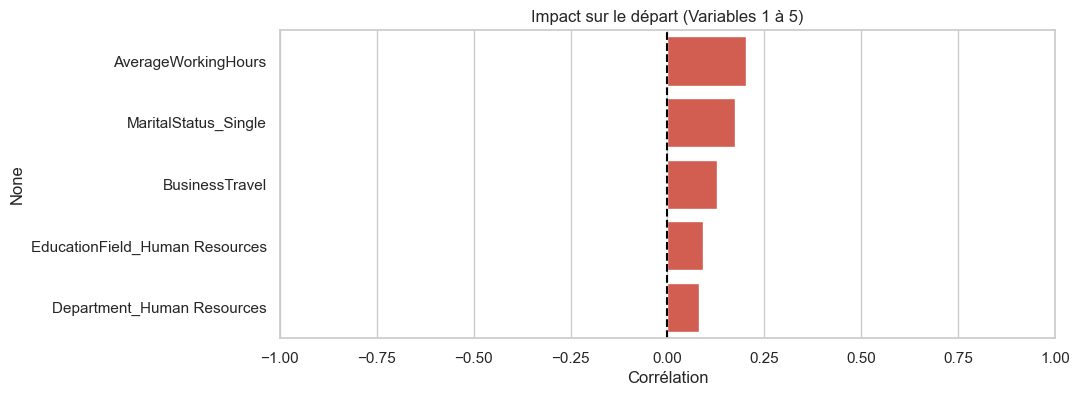

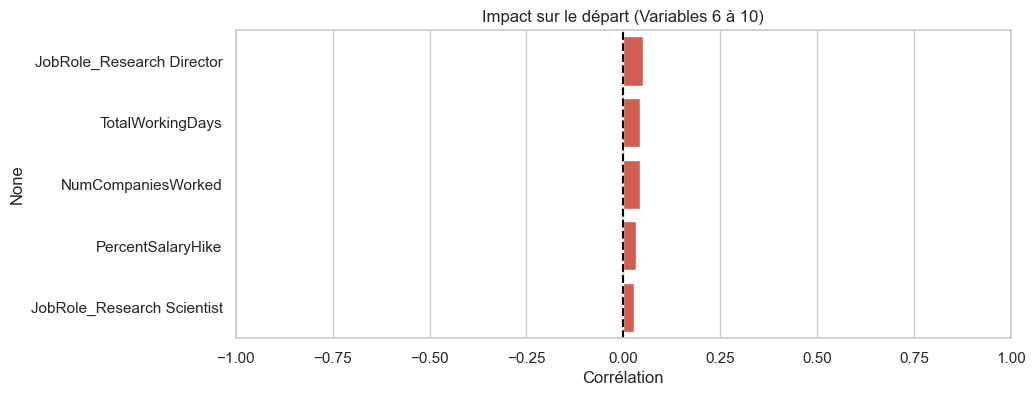

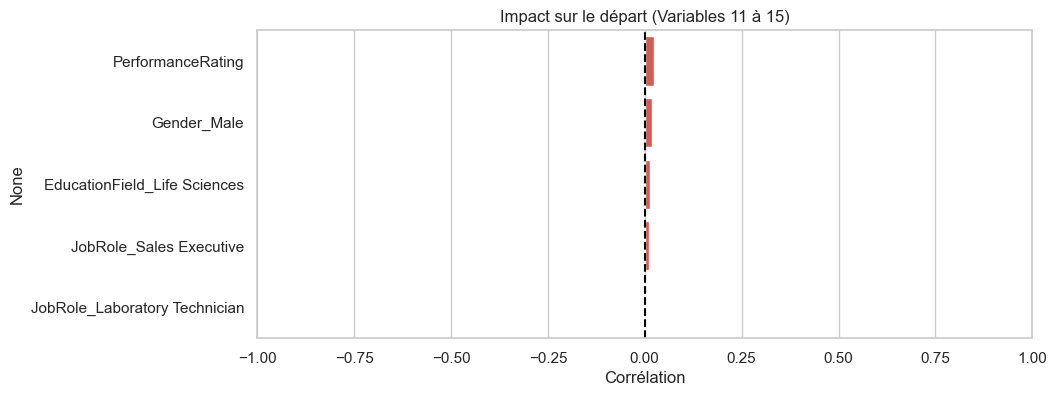

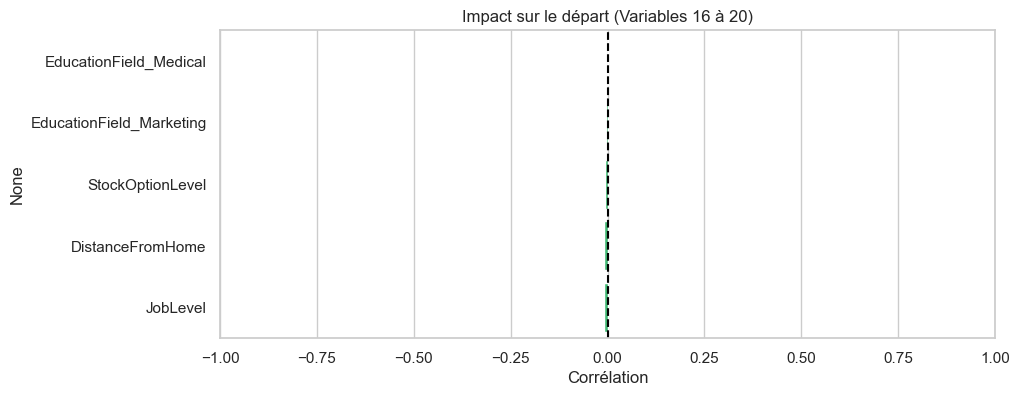

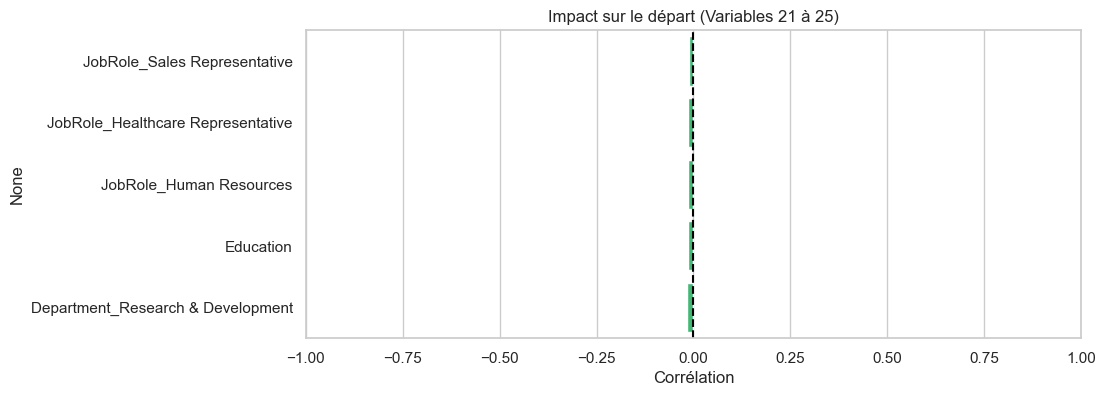

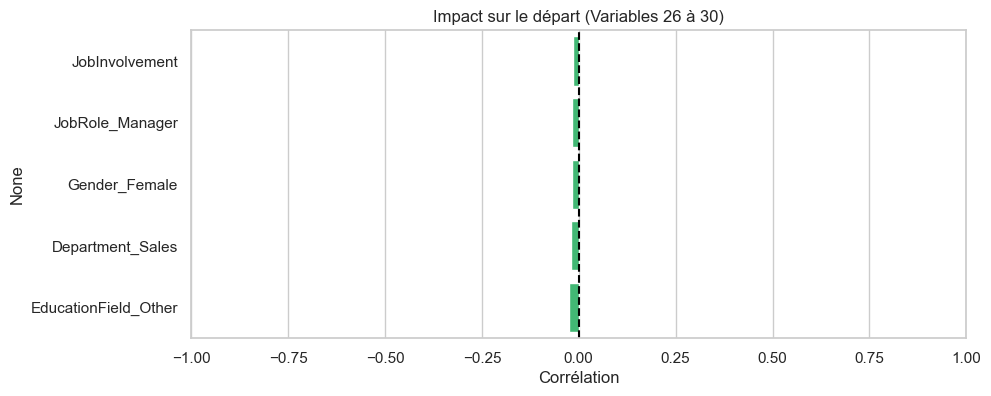

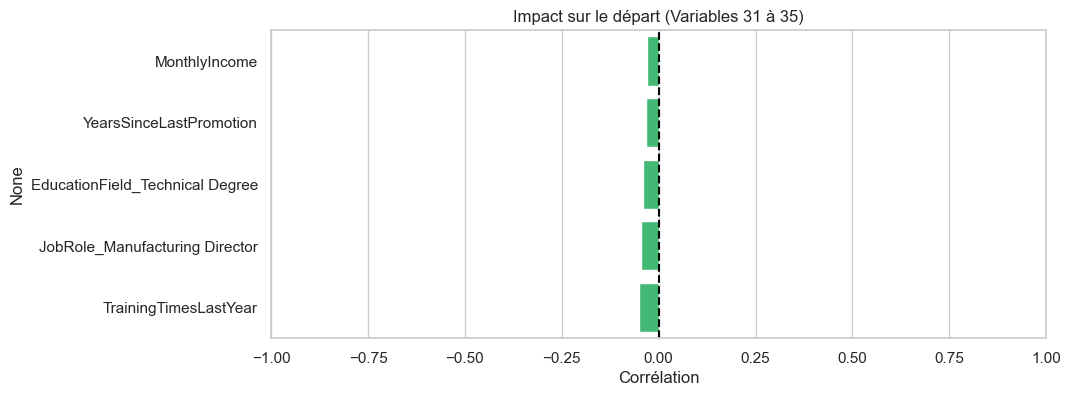

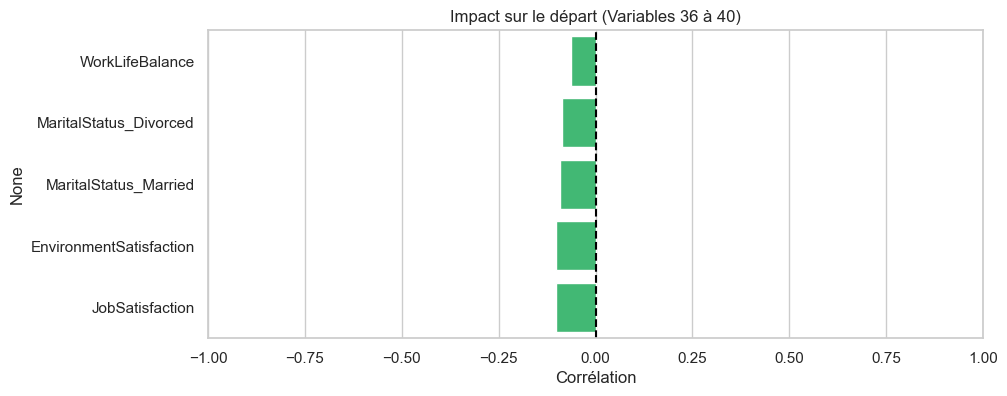

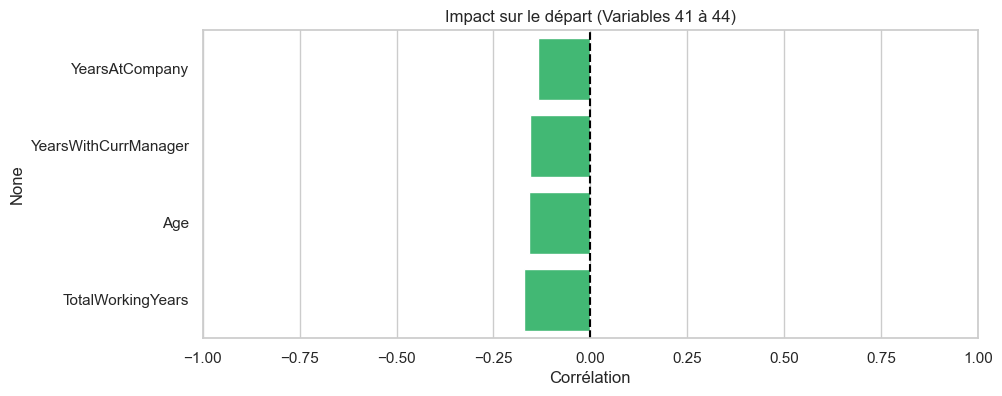


   Génération de la Heatmap (Top 15 variables clés)...


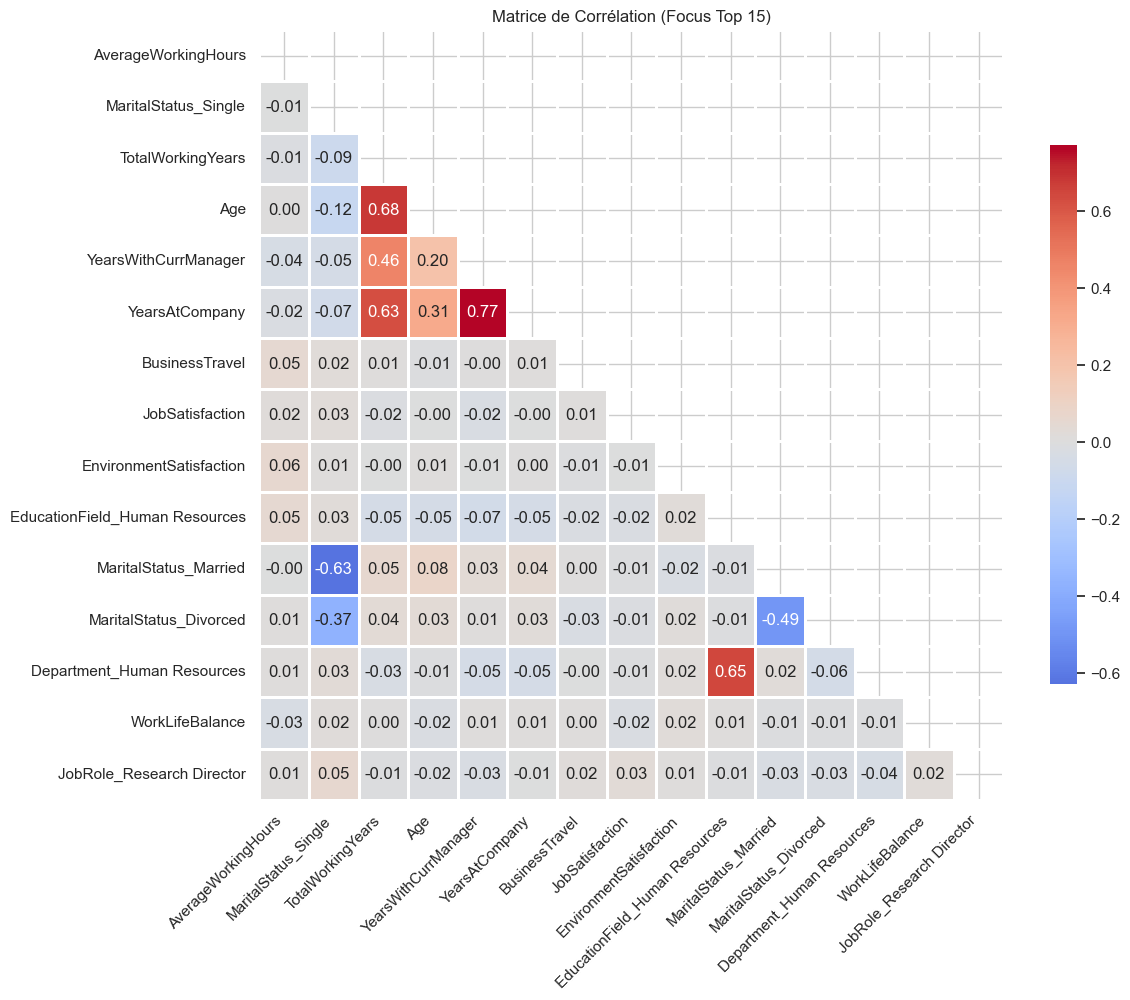

 Préparation des données (Train/Test Split)...
   Train set : 3087 employés
   Test set  : 1323 employés

 Début de l'entraînement des modèles...
------------------------------------------------------------
   🔹 LogisticRegression   | Recall Test: 0.244 | CV Recall Moy: 0.235
   🔹 Perceptron           | Recall Test: 0.127 | CV Recall Moy: 0.394
   🔹 SVM                  | Recall Test: 0.338 | CV Recall Moy: 0.335
   🔹 KNN                  | Recall Test: 0.300 | CV Recall Moy: 0.313
   🔹 NaiveBayes           | Recall Test: 0.366 | CV Recall Moy: 0.372
   🔹 DecisionTree         | Recall Test: 0.892 | CV Recall Moy: 0.805
   🔹 RandomForest         | Recall Test: 0.911 | CV Recall Moy: 0.811
   🔹 XGBoost              | Recall Test: 0.934 | CV Recall Moy: 0.859
   🔹 ReseauNeuronal       | Recall Test: 0.920 | CV Recall Moy: 0.872

 CLASSEMENT FINAL (Trié par Recall & F1-Score) :


,Modèle,Accuracy,Precision,Recall,CV Recall Moyen,CV Ecart-Type,F1-Score,AUC,Temps (s)
7,XGBoost,0.983371,0.961353,0.934272,0.859495,0.035076,0.947619,0.980227,0.567204
8,ReseauNeuronal,0.984883,0.984925,0.920188,0.871556,0.030989,0.951456,0.980053,22.740950
6,RandomForest,0.983371,0.984772,0.910798,0.811313,0.048218,0.946341,0.987296,1.993552
5,DecisionTree,0.968254,0.909091,0.892019,0.805212,0.023589,0.900474,0.937451,0.151918
4,NaiveBayes,0.832200,0.472727,0.366197,0.371556,0.022147,0.412698,0.755623,0.040513
2,SVM,0.885110,0.867470,0.338028,0.335394,0.062510,0.486486,0.898401,4.817596
3,KNN,0.833711,0.474074,0.300469,0.313273,0.033857,0.367816,0.868090,0.069787
0,LogisticRegression,0.853364,0.611765,0.244131,0.234828,0.027907,0.348993,0.801011,0.092783
1,Perceptron,0.840514,0.519231,0.126761,0.393677,0.189492,0.203774,0.000000,0.041243



 Génération des matrices de confusion...


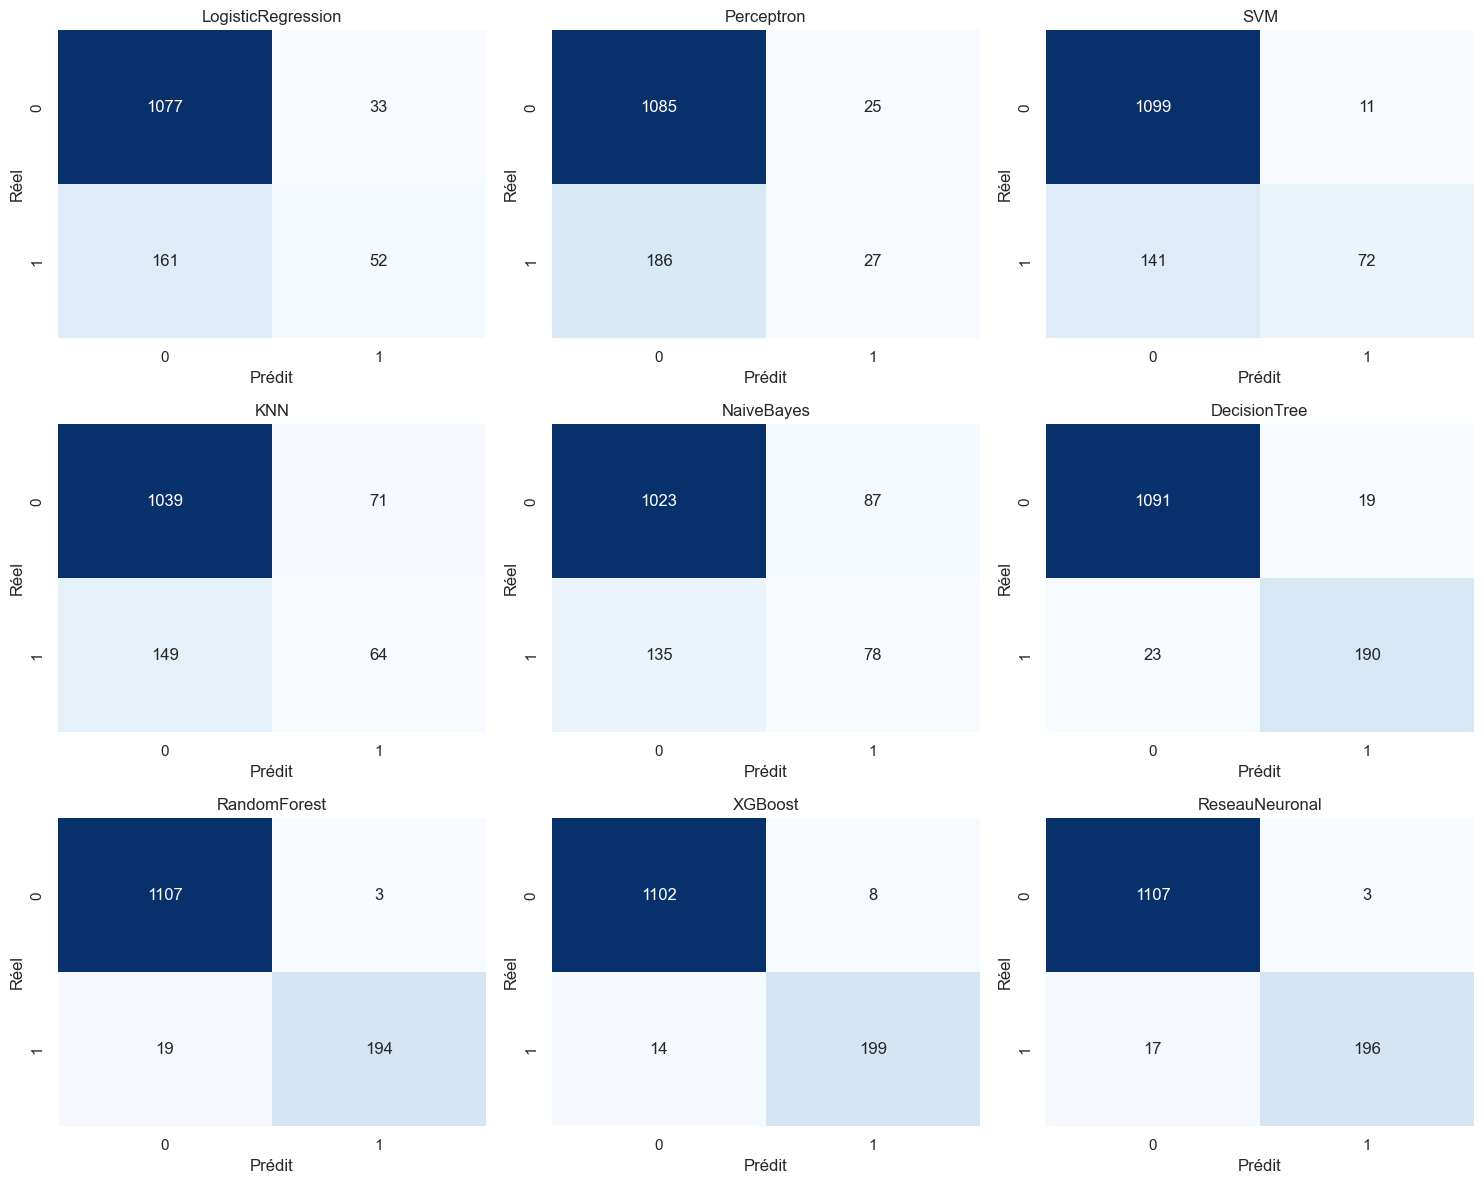


 Analyse des causes réelles du départ (Basé sur : XGBoost)...


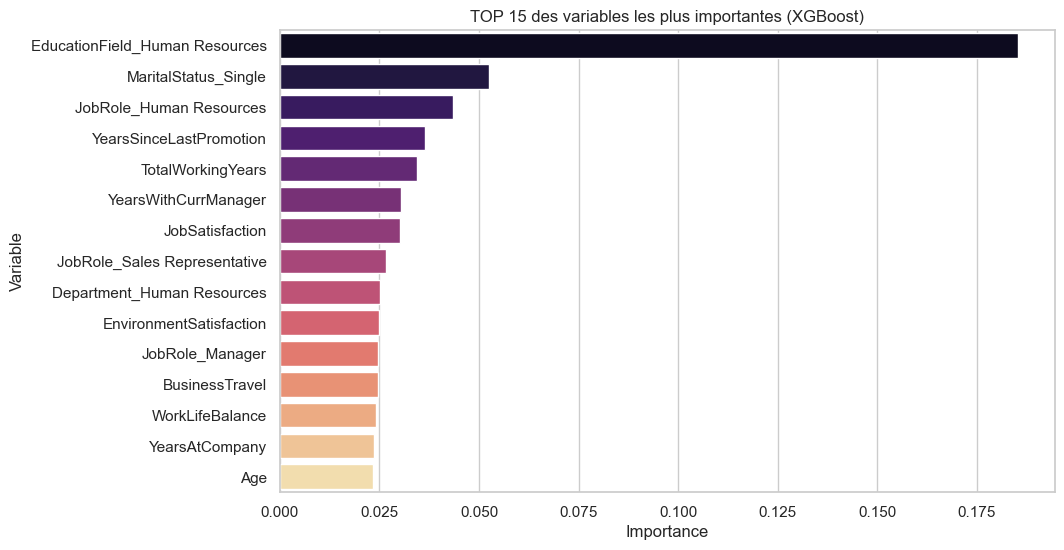


📊 Génération de la comparaison ROC/AUC...


C:\Users\gdani\AppData\Local\Temp\ipykernel_23388\3764132910.py:86: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "k--" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--', color='grey', label="Hasard (AUC = 0.5)")
C:\Users\gdani\AppData\Local\Temp\ipykernel_23388\3764132910.py:86: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, 1], [0, 1], 'k--', linestyle='--', color='grey', label="Hasard (AUC = 0.5)")


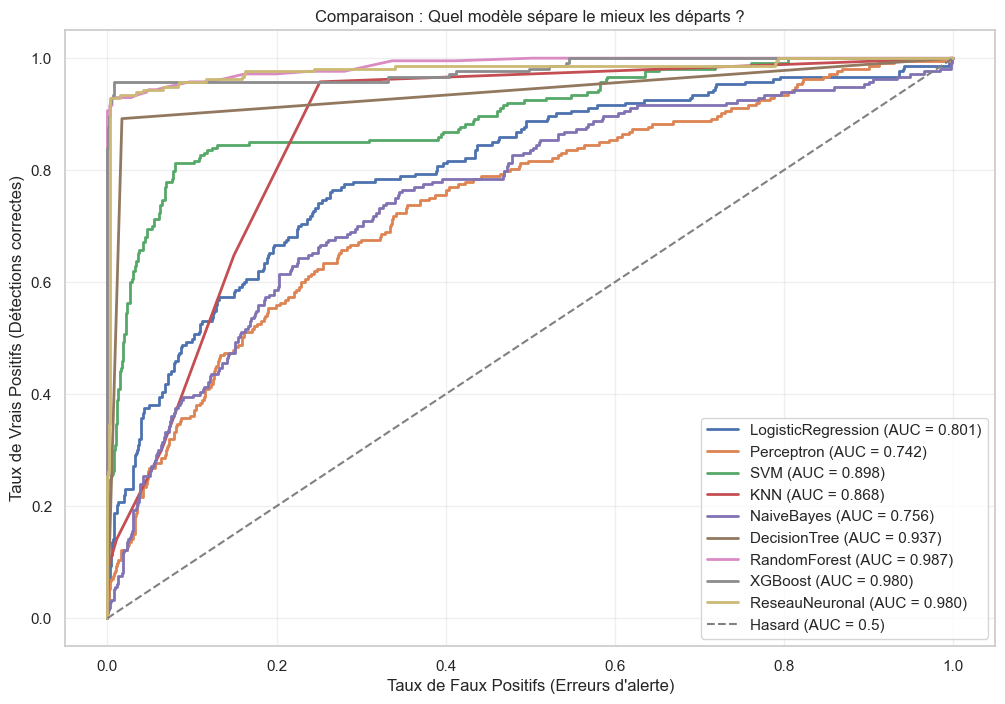

🏆 Le modèle champion est : RandomForest avec un AUC de 0.987


In [18]:
# 1. Chemin du fichier
fichier_csv = 'data/processed_hr_data_encoded_normalized.csv'

# 2. Chargement
df = charger_donnees(fichier_csv)

if df is not None:
    # 3. Analyse  de Corrélation
    analyser_facteurs_influents(df)

    # 4. Préparation
    X_train, X_test, y_train, y_test, feature_names = preparation_donnees(df)
    
    # 5. Entraînement
    resultats_df, modeles_entraines = entrainer_modeles(X_train, X_test, y_train, y_test)
    
    # 6. Tableau des résultats
    print("\n CLASSEMENT FINAL (Trié par Recall & F1-Score) :")
    display(resultats_df.sort_values(by=['Recall', 'F1-Score'], ascending=False))
    
    # 7. Graphiques
    afficher_matrice_confusion(y_test, modeles_entraines, X_test)
    afficher_importance_variables(modeles_entraines, feature_names)
    meilleur_modele_nom = comparer_roc_auc_visuel(modeles_entraines, X_test, y_test)
